$\textbf{Connessione al file excel}$ condiviso con ispra su onedrive e pulizia dei dati non necessari per l'analisi

In [1]:
#import section
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

#richiesta e scrittura del file
url = 'https://onedrive.live.com/download.aspx?resid=214F842E8CF74F00!1571&ithint=file%2cxlsx&authkey=!AJLou3yLbKPnlLo'
r = requests.get(url)
open('temp.xls', 'wb').write(r.content)

#creazione dei due dataframe - resource description/resource location
df1 = pd.read_excel('temp.xls', 'Resource location')
df2 = pd.read_excel('temp.xls', 'Resource description')

#eliminazione delle colonne non necessarie per l'analisi
df1 = df1.drop(['sub_resource_name'], axis=1)
df2 = df2.drop(['Resource title', 'Resource abstract', 'Temporal extent',
       'Update frequency', 'Language', 'CRS',
       'Representation type', 'Format',
       'Spatial Resolution (Scale or grid size)', 'MMU', 'INSPIRE theme',
       'Access conditions', 'Proliferation in CLC+ instances allowed?',
       'Data costs', 'Resource locator (URL)', 'Resource provider',
       'INSPIRE locator', 'CORDA locator', 'Comments', 'New URL',
       'Unnamed: 22'], axis=1)

#join delle due tabelle sulla base dell'id
result = df1.join(df2, on="resource_id")

#display del dataframe
result

result.to_csv(r'/Users/francesco/Desktop/tot_csv.csv')


/Users/francesco/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/Users/francesco/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Importazione di uno $\textbf{shapefile delle regioni italiane}$ per l'analisi

In [2]:
italy = gpd.GeoDataFrame.from_file('italian_regions/Reg01012022_g_WGS84.shp')
italy = gpd.read_file('italian_regions/Reg01012022_g_WGS84.shp')[['COD_REG','DEN_REG','geometry']]
for i in range(len(italy.DEN_REG)):
    italy.DEN_REG[i] = italy.DEN_REG[i].upper()

/var/folders/wk/ppkwh92d4hb_1fqwtwsw63n80000gn/T/ipykernel_10608/665290006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italy.DEN_REG[i] = italy.DEN_REG[i].upper()


$\textbf{Unifomare i nomi delle regioni}$ nelle due diverse datasources

In [3]:
#estraggo lista nomi regioni da geodataframe
region_names = list(italy.DEN_REG)

#rendo nomi regioni maiuscoli per uniformare
for i in range (len(region_names)):
    region_names[i] = region_names[i].upper() 

I valori consideati per l'analisi sono:

    - % di risorse per cui sono riportati i metadati in formato XML
    - % di risorse per cui sono riportati i meradati in "formato pagina web"
    - % di risorse per cui è riportata la licenza applicata sui dati
    - % di risorse per cui è disponibile il Direct Download dei dati
    - % di risorse per cui è disponibile la WFS request
    - % di risorse per cui è disponibile la WMS request
    - % di risorse per cui è disponibile la connessione all'ArcGis REST server
    - % di risorse per cui la WFS request fornita funziona
    - % di risorse per cui la WMS request fornita funziona
    - % di risorse per cui la connessione all'ArcGis REST server funziona

sono anche stati calcolati 3 indici atti a stimare:

- REPERIBILITA': $XML \bullet 0.6 + SITE \bullet 0.2 + LICENSE \bullet 0.2$

- ACCESSIBILITA': $DD \bullet 0.5 + WFS \bullet 0.15 + WMS \bullet 0.10 + ARC \bullet 0.25$

- SCORE GLOBALE: $REPERIBILITA' \bullet 0.5 + ACCESSIBILITA' \bullet 0.5$

In [4]:
#calcolo valori fondamentali e scores per ogni regione
region_scores = []
for i in range(len(region_names)):
    
    
    partial = result[result.Coverage == region_names[i]]
    
    #totale risorse analizzate per singola regione
    tot = len(partial.index)
    
    
    # INFO SULLA REPERIBILITà +++++++++++++++++++++++++++++++++++++++++++++++
    #risorse con metadati XML per singola regione
    num_xml = len(partial.dropna(axis=0, how='all', subset=['metadata_xml']))
    #risorse con metadati "sito" per singola regione
    num_site = len(partial.dropna(axis=0, how='all', subset=['metadata_site']))
    #risorse delle quali è specificata la licenza per singola regione
    num_license = len(partial.dropna(axis=0, how='all', subset=['license']))
    
    # INFO SULLA ACCESSIBLITà +++++++++++++++++++++++++++++++++++++++++++++++
    #risorse delle quali è disponibile il direct download per singola regione
    num_dd = len(partial.dropna(axis=0, how='all', subset=['direct_download']))
    
    #risorse per le quali è fornita qualche tipo di request per singola regione
    num_wfs_provided = len(partial.dropna(axis=0, how='any', subset=['wfs','wfs_provided_score']))
    num_wms_provided = len(partial.dropna(axis=0, how='any', subset=['wms','wfs_provided_score']))
    num_arc_provided = len(partial.dropna(axis=0, how='any', subset=['ArcGis_REST_server','ArcGis_REST_server_provided_score']))
    
    #risorse delle quali la request fornita è funzionante per singola regione
    temp = partial.dropna(axis=0, how='any', subset=['wfs','wfs_provided_score'])
    num_wfs_provided_working = len(temp[temp.wfs_provided_score == 'provided-working-2'])
    temp = partial.dropna(axis=0, how='any', subset=['wms','wms_provided_score'])
    num_wms_provided_working = len(temp[temp.wms_provided_score == 'provided-working-2'])
    temp = partial.dropna(axis=0, how='any', subset=['ArcGis_REST_server','ArcGis_REST_server_provided_score'])
    num_arc_provided_working = len(temp[temp.ArcGis_REST_server_provided_score == 'provided-working-2'])
    
    
    try:
        xml = num_xml/tot
        site = num_site/tot
        license = num_license/tot
        dd = num_dd/tot
        wfs_p = num_wfs_provided/tot
        wms_p = num_wms_provided/tot
        arc_p = num_arc_provided/tot
    except:
        xml = 0
        site = 0
        license = 0
        dd = 0
        wfs_p = 0
        wms_p = 0
        arc_p = 0
        
        
    try:
        wfs_p_w = num_wfs_provided_working/num_wfs_provided
    except:
        wfs_p_w = 0
        
    try:
        wms_p_w = num_wms_provided_working/num_wms_provided
    except:    
        wms_p_w = 0
        
    try:
        arc_p_w = num_arc_provided_working/num_arc_provided
    except:
        arc_p_w = 0
        
    rep = xml*0.6 + site*0.2 + license*0.2
    acc = dd*0.5 + wfs_p_w*0.15 + wms_p_w*0.1 + arc_p_w*0.25
    score = rep*0.5 + acc*0.5
        

    single_region = [region_names[i],xml, site, license, dd, wfs_p, wms_p, arc_p, wfs_p_w, wms_p_w, arc_p_w, rep, acc, score]
    region_scores.append(single_region)
    
scores = pd.DataFrame(region_scores, columns= ['region_name','meta_xml','meta_site','license','direct_download','provided_wfs','provided_wms','provided_ArgGIS_server','working_wfs','working_wms','working_ArgGIS_server','reperibilita_globale','accessibilita_globale','SCORE'])

In [5]:
#join del godataframe con gli score calcolati
merged_df = italy.merge(scores, left_on="DEN_REG", right_on="region_name")

<AxesSubplot:>

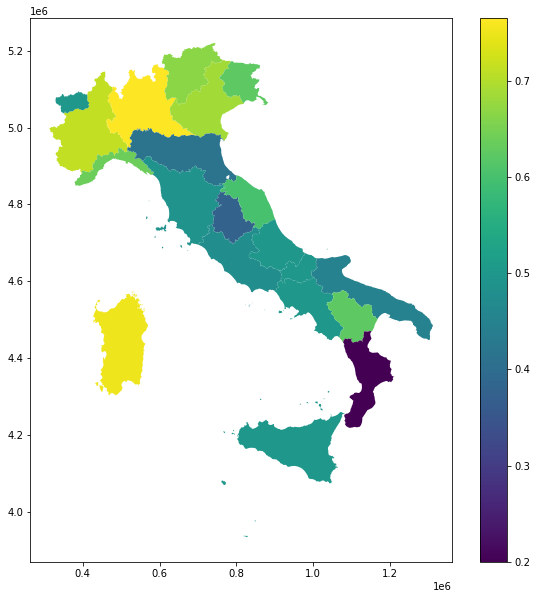

In [6]:
#creazione del plot
merged_df.plot(column="SCORE", figsize=(10,10), legend=True)

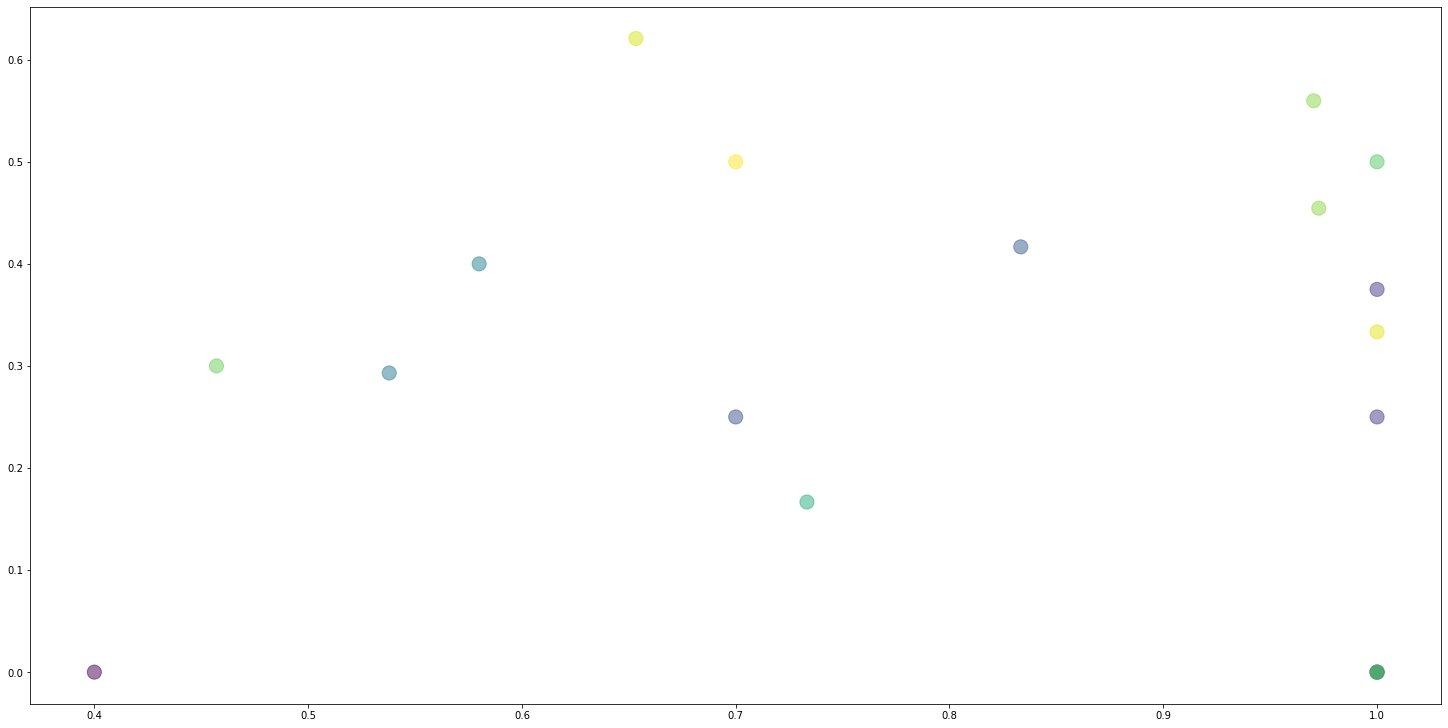

In [7]:
#plot nello spazio dei due scores per ogni region (ogni punto è una regione)
x = merged_df.reperibilita_globale
y = merged_df.accessibilita_globale
colors = np.random.rand(20)

plt.figure(figsize=(20,10), edgecolor='white', constrained_layout=True)
plt.scatter(x, y, c=colors, alpha=0.5, s=200)
plt.show()

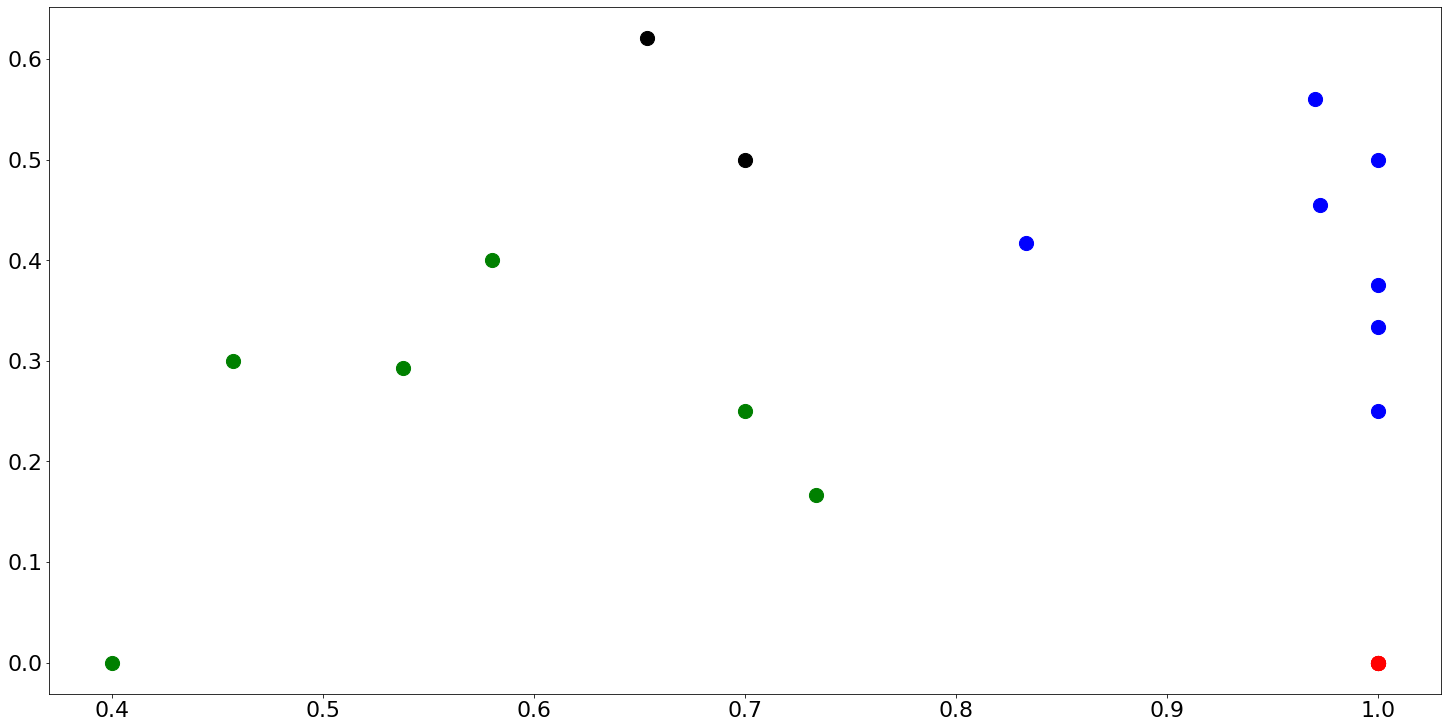

In [14]:
#applicazione di un Unsupervised Machine Learning algorithm per trovare 3 clusters di regioni
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters = 4)

label = k_means.fit_predict(merged_df[['reperibilita_globale', 'accessibilita_globale']])

filtered_label1 = merged_df[label == 0]
filtered_label2 = merged_df[label == 1]
filtered_label3 = merged_df[label == 2]
filtered_label4 = merged_df[label == 3]

plt.figure(figsize=(20,10), edgecolor='white', constrained_layout=True)

plt.scatter(filtered_label1.reperibilita_globale , filtered_label1.accessibilita_globale , color = 'red', s=200)
plt.scatter(filtered_label2.reperibilita_globale , filtered_label2.accessibilita_globale , color = 'black', s=200)
plt.scatter(filtered_label3.reperibilita_globale , filtered_label3.accessibilita_globale , color = 'blue', s= 200)
plt.scatter(filtered_label4.reperibilita_globale , filtered_label4.accessibilita_globale , color = 'green', s= 200)
plt.show()

In [9]:
merged_df

,COD_REG,DEN_REG,geometry,region_name,meta_xml,meta_site,license,direct_download,provided_wfs,provided_wms,provided_ArgGIS_server,working_wfs,working_wms,working_ArgGIS_server,reperibilita_globale,accessibilita_globale,SCORE
0,1,PIEMONTE,"POLYGON ((457749.464 5145501.795, 458662.395 5...",PIEMONTE,0.954545,1.000000,1.000000,0.909091,0.000000,0.000000,0.181818,0.00,0.00,0.0,0.972727,0.454545,0.713636
1,2,VALLE D'AOSTA,"POLYGON ((390652.644 5091766.171, 390748.643 5...",VALLE D'AOSTA,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,1.000000,0.000000,0.500000
2,3,LOMBARDIA,"MULTIPOLYGON (((485536.366 4985444.605, 485366...",LOMBARDIA,1.000000,0.851852,1.000000,0.629630,0.370370,0.370370,0.666667,0.70,1.40,0.0,0.970370,0.559815,0.765093
3,4,TRENTO,"POLYGON ((743267.749 5219765.793, 743387.812 5...",TRENTO,1.000000,1.000000,1.000000,0.666667,0.000000,0.000000,0.000000,0.00,0.00,0.0,1.000000,0.333333,0.666667
4,5,VENETO,"POLYGON ((768123.960 5175397.497, 768135.210 5...",VENETO,1.000000,1.000000,1.000000,0.750000,0.000000,0.000000,0.000000,0.00,0.00,0.0,1.000000,0.375000,0.687500
5,6,FRIULI VENEZIA GIULIA,"MULTIPOLYGON (((872344.457 5061894.048, 872344...",FRIULI VENEZIA GIULIA,0.833333,0.833333,0.833333,0.333333,0.166667,0.166667,0.000000,1.00,1.00,0.0,0.833333,0.416667,0.625000
6,7,LIGURIA,"MULTIPOLYGON (((568226.691 4874823.573, 568219...",LIGURIA,0.600000,0.466667,1.000000,0.866667,0.266667,0.266667,0.266667,0.75,0.75,0.0,0.653333,0.620833,0.637083
7,8,EMILIA ROMAGNA,"MULTIPOLYGON (((618343.929 4893985.661, 618335...",EMILIA ROMAGNA,0.413793,0.655172,0.793103,0.586207,0.000000,0.000000,0.344828,0.00,0.00,0.0,0.537931,0.293103,0.415517
8,9,TOSCANA,"MULTIPOLYGON (((674426.642 4680710.364, 674563...",TOSCANA,0.500000,0.500000,0.900000,0.800000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.580000,0.400000,0.490000
9,10,UMBRIA,"MULTIPOLYGON (((776982.140 4832209.918, 776910...",UMBRIA,0.257143,0.771429,0.742857,0.600000,0.000000,0.000000,0.228571,0.00,0.00,0.0,0.457143,0.300000,0.378571


In [10]:
def regional_report(nome_regione):
    nome_regione = nome_regione.upper()
    row = merged_df[merged_df.region_name == nome_regione]
    
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(20,20), edgecolor='white', constrained_layout=True)
    fig.suptitle(nome_regione, fontsize=40)
    for col,i in zip(merged_df.columns[4:14], range(len(merged_df.columns[3:13]))):
        plt.subplot(5,2,i+1)
        plt.pie([float(row[col]),abs(1-float(row[col]))],radius = 1.7, labels=['disponibili','non disponibili'],autopct='%0.1f%%')
        plt.title(col)
    plt.show()
    

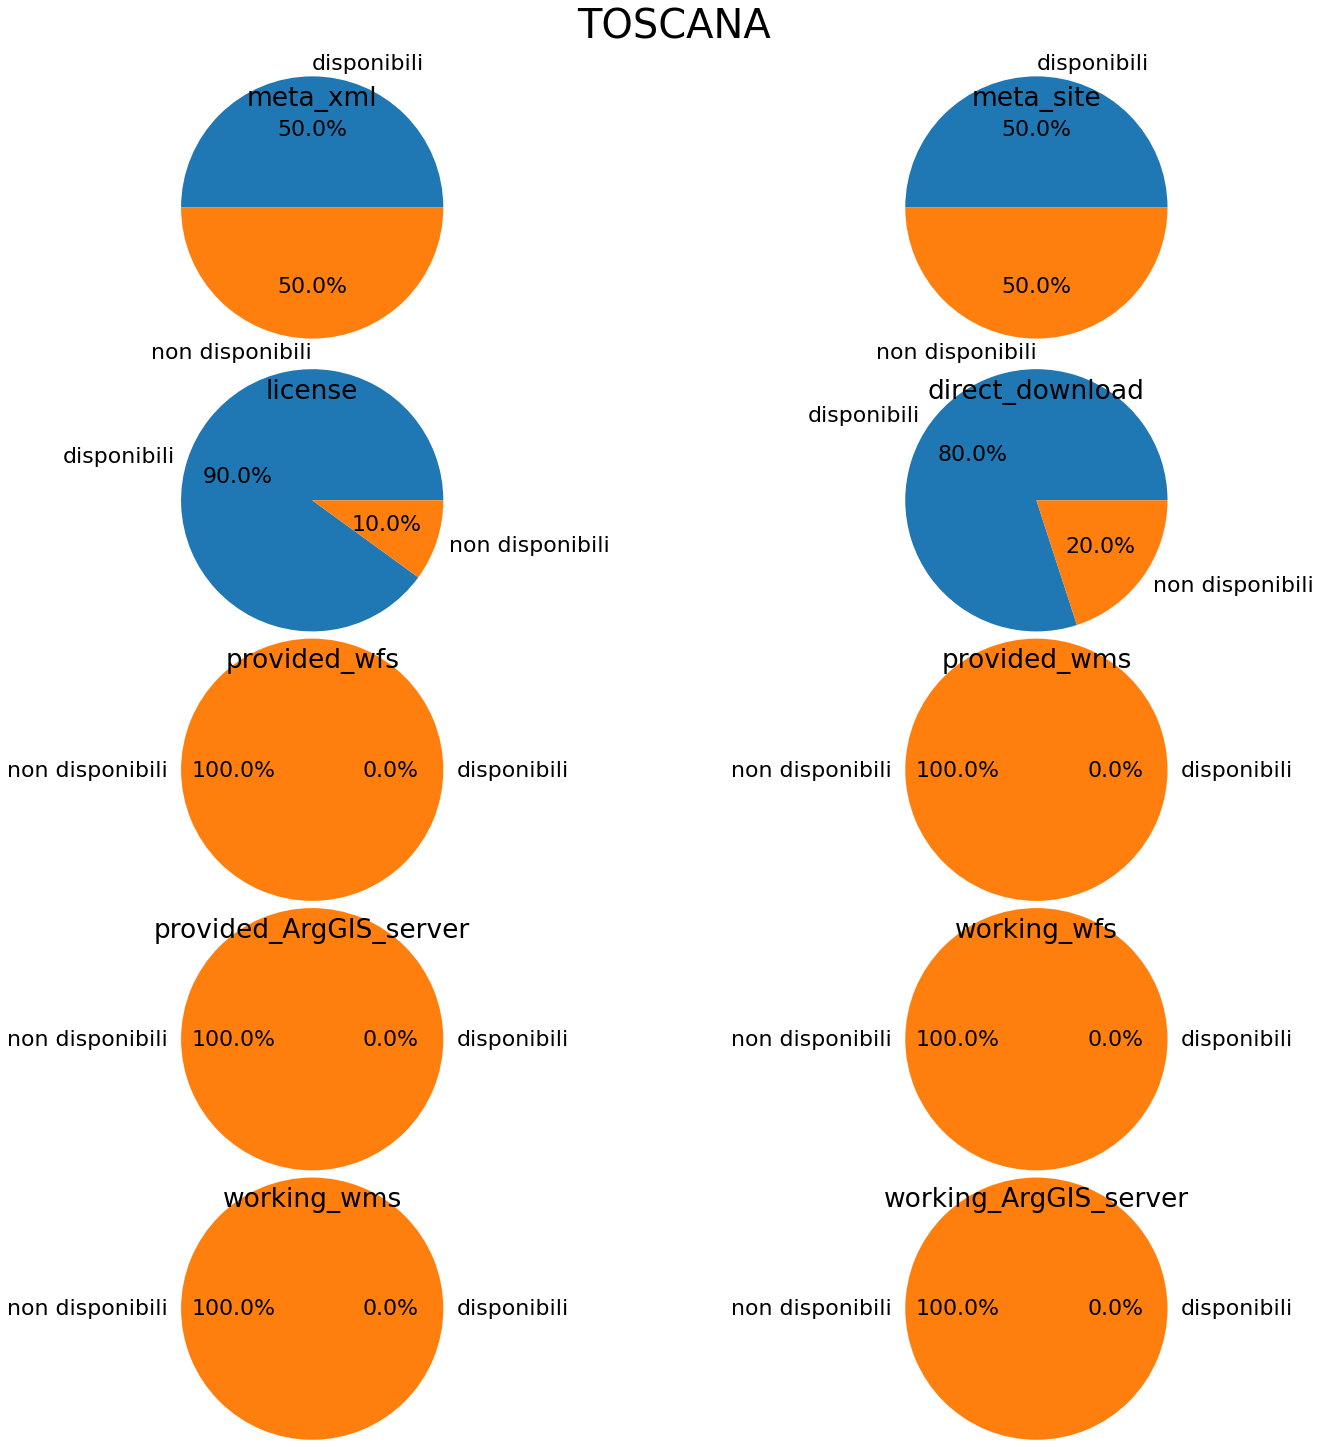

In [11]:
regional_report('Toscana')